In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import t

In [5]:
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    "#000072", # blue (for historical data)
    "#80c21d", # green (for actual data)
    "#924eae", # purple
    "#ff0000", # red
    "#ff9100", # orange
])

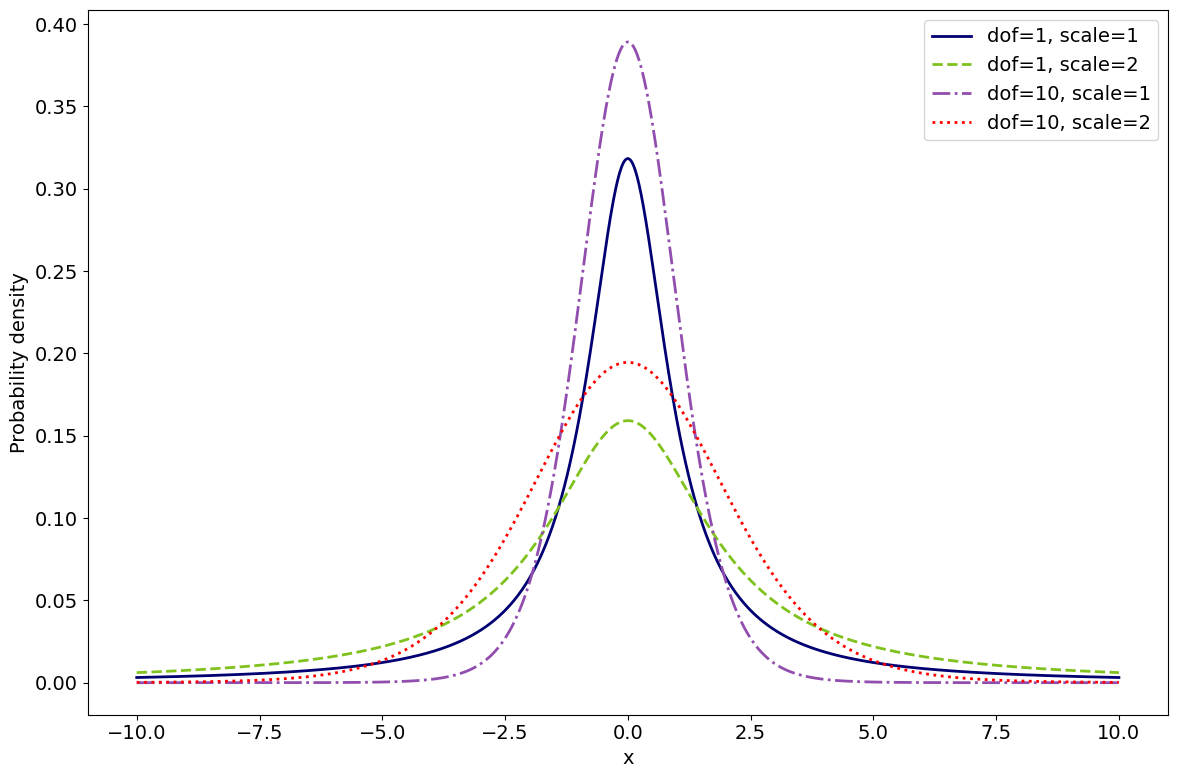

In [6]:
dofs = [1, 10]
mean = 0
std_devs = [1, 2]

x = np.linspace(-10, 10, 1000)
linestyles = ['-', '--', '-.', ':']

plt.figure(figsize=(12, 8))

for i, dof in enumerate(dofs):
    for j, std_dev in enumerate(std_devs):
        y = t.pdf(x, dof, loc=mean, scale=std_dev)
        ls = linestyles[(i*2+j) % 4]
        plt.plot(x, y, linestyle=ls, label=f'dof={dof}, scale={std_dev}')

plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()

plt.tight_layout()
plt.savefig('figures/CH04_F03_peixeiro2.png', dpi=300)
plt.savefig('figures/CH04_F03_peixeiro2.pdf', format='pdf', bbox_inches='tight')

## Initial setup

In [7]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [8]:
cd lag-llama

D:\DataScienceWithMarco\book2\code\FoundationModelsForTimeSeriesForecasting\CH04\lag-llama


D:\Anaconda\envs\book-env\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
!pip install -r requirements.txt

In [10]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir ./

lag-llama.ckpt


## Zero-shot forecasting

In [11]:
import torch
import pandas as pd

from gluonts.dataset.pandas import PandasDataset

from lag_llama.gluon.estimator import LagLlamaEstimator

D:\Anaconda\envs\book-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
def get_lag_llama_predictions(dataset, 
                              prediction_length, 
                              device, 
                              context_length=32, 
                              num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecasts = predictor.predict(
        dataset=dataset,
    )

    forecasts = list(forecasts)
    return forecasts

In [13]:
df = pd.read_csv('../../data/walmart_sales_small.csv', parse_dates=['Date'])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [14]:
df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

In [15]:
dataset = PandasDataset.from_long_dataframe(df, target="Weekly_Sales", item_id="Store")

prediction_length = 8 
device = torch.device("cpu") 

In [16]:
forecasts = get_lag_llama_predictions(dataset, prediction_length, device)

In [17]:
forecasts[0].samples.shape

(100, 8)

In [18]:
import numpy as np

def get_median_and_ci(
    data, 
    start_date,
    horizon,
    freq,
    id,
    confidence=0.95
):

    n_samples, n_timesteps = data.shape
    
    # Calculate the median for each timestep
    medians = np.median(data, axis=0)
    
    # Calculate the lower and upper percentile for the given confidence interval
    lower_percentile = (1 - confidence) / 2 * 100
    upper_percentile = (1 + confidence) / 2 * 100
    
    # Calculate the lower and upper bounds for each timestep
    lower_bounds = np.percentile(data, lower_percentile, axis=0)
    upper_bounds = np.percentile(data, upper_percentile, axis=0)

    pred_dates = pd.date_range(start=start_date, periods=horizon, freq=freq)
    formatted_dates = pred_dates.strftime('%m-%d-%Y').tolist()
    
    # Create a DataFrame with the results
    df = pd.DataFrame({
        'Date': formatted_dates,
        'Store': id,
        'Lag-Llama': medians,
        f'Lag-Llama-lo-{int(confidence*100)}': lower_bounds,
        f'Lag-Llama-hi-{int(confidence*100)}': upper_bounds
    })
    
    return df

In [19]:
preds = [
    get_median_and_ci(
        data=forecasts[i].samples,
        start_date='11-02-2012',
        horizon=8,
        freq='W-FRI',
        id=i+1
    )
    for i in range(4)
]

preds_df = pd.concat(preds, axis=0, ignore_index=True)
preds_df['Date'] = pd.to_datetime(preds_df['Date'])

preds_df.head()

,Date,Store,Lag-Llama,Lag-Llama-lo-95,Lag-Llama-hi-95
0,2012-11-02,1,1537269.875,9.732263e+05,1.932659e+06
1,2012-11-09,1,1512569.750,9.308486e+05,2.132849e+06
2,2012-11-16,1,1489036.750,9.388767e+05,1.852226e+06
3,2012-11-23,1,1532170.000,1.009671e+06,2.181528e+06
4,2012-11-30,1,1486190.250,9.650241e+05,1.976400e+06


In [20]:
plot_df = df.reset_index(drop=True).copy()
plot_preds_df = preds_df.copy()

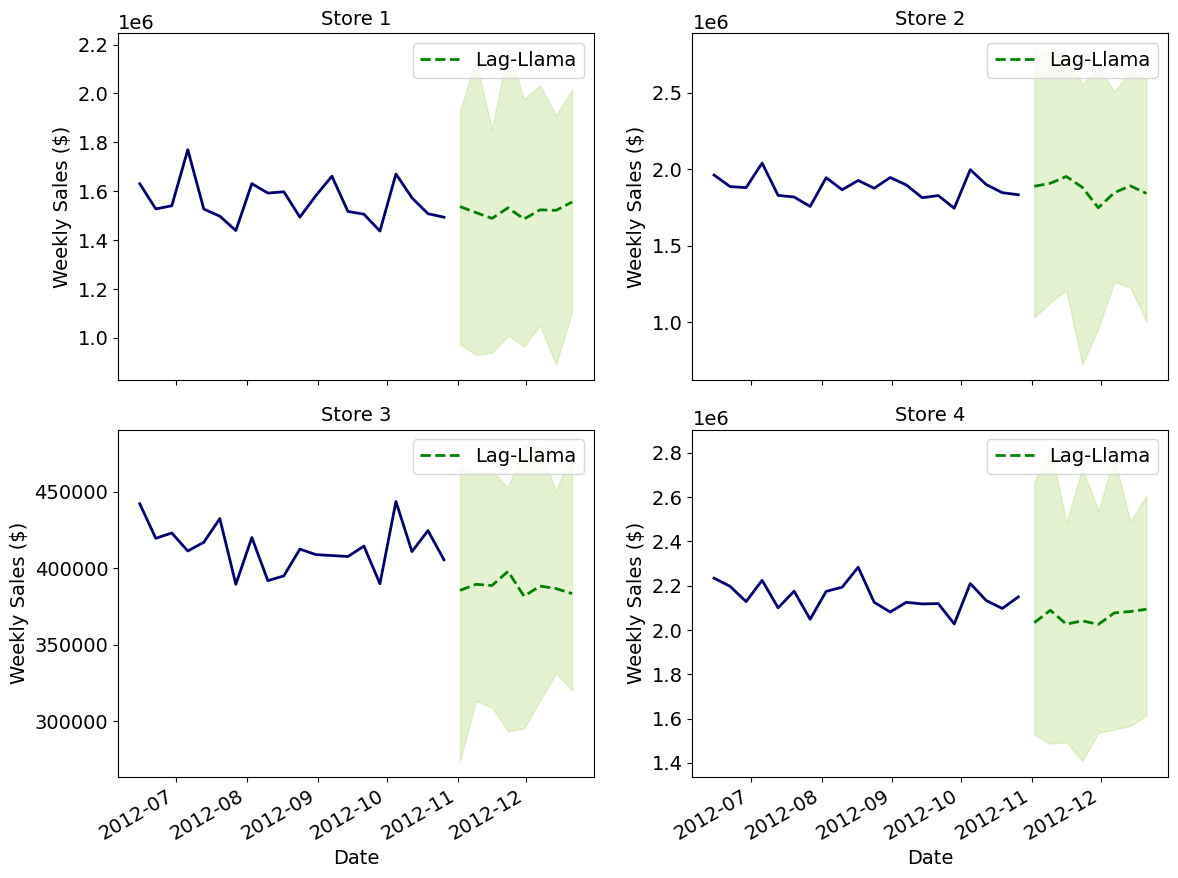

In [21]:
import matplotlib.pyplot as plt

df = df.reset_index(drop=True)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    df = plot_df[plot_df['Store'] == i+1].iloc[-20:]
    preds_df = plot_preds_df[plot_preds_df['Store'] == i+1]

    ax.plot(df['Date'], df['Weekly_Sales'])
    ax.plot(preds_df['Date'], preds_df['Lag-Llama'], 'g--', label='Lag-Llama')
    ax.fill_between(preds_df['Date'], preds_df['Lag-Llama-lo-95'], preds_df['Lag-Llama-hi-95'], alpha=0.2, color='#80c21d')
    ax.legend()
    ax.set_title(f'Store {i+1}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weekly Sales ($)')

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('../figures/CH04_F04_peixeiro2.png', dpi=300)
plt.savefig('../figures/CH04_F04_peixeiro2.pdf', format='pdf', bbox_inches='tight')

## Tuning the context length

In [22]:
df = pd.read_csv('../../data/walmart_sales_small.csv', parse_dates=['Date'])
df = df[df['Store'] == 1]

input_df = df[:-32]
test_df = df[-32:]

In [23]:
df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

In [24]:
def cross_validation_lagllama(df, h, n_windows, device, context_length, confidence=0.95):

    all_forecasts = []
    
    for i in range(n_windows, 0, -1):
        input_ds = PandasDataset.from_long_dataframe(
            df[:-(h * i)], 
            target="Weekly_Sales", 
            item_id="Store"
        )
        
        # Generate predictions
        forecasts = get_lag_llama_predictions(input_ds, h, device, context_length)
        
        # Get start date for predictions (first date after training cutoff)
        start_date = df.iloc[-(h * i)]['Date']
        
        # Format predictions with confidence intervals
        forecast_df = get_median_and_ci(
            data=forecasts[0].samples, 
            start_date=start_date,
            horizon=h,
            freq='W-FRI',  
            id=1,
            confidence=confidence
        )
        all_forecasts.append(forecast_df)
    
    # Combine all windows and sort by date
    final_df = pd.concat(all_forecasts, axis=0, ignore_index=True)
    final_df = final_df.sort_values('Date')
    
    return final_df

In [25]:
prediction_length = 8 
device = torch.device("cpu") 

In [26]:
fcsts_16 = cross_validation_lagllama(
    df=df,
    h=8,
    n_windows=4,
    device=device,
    context_length=16
)

fcsts_32 = cross_validation_lagllama(
    df=df,
    h=8,
    n_windows=4,
    device=device,
    context_length=32
)

fcsts_64 = cross_validation_lagllama(
    df=df,
    h=8,
    n_windows=4,
    device=device,
    context_length=64
)

In [27]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

eval_df = test_df[['Date', 'Store', 'Weekly_Sales']].copy()

eval_df.loc[:, 'Lag-Llama(16)'] = fcsts_16['Lag-Llama'].values
eval_df.loc[:, 'Lag-Llama(32)'] = fcsts_32['Lag-Llama'].values 
eval_df.loc[:, 'Lag-Llama(64)'] = fcsts_64['Lag-Llama'].values 

evaluation = evaluate(
    eval_df,
    metrics=[mae, smape],
    target_col='Weekly_Sales',
    id_col='Store',
    time_col='Date'
)

evaluation

,Store,metric,Lag-Llama(16),Lag-Llama(32),Lag-Llama(64)
0,1,mae,88008.200313,89130.719375,82125.334531
1,1,smape,0.027731,0.028061,0.025803


In [28]:
fcsts_64.head()

,Date,Store,Lag-Llama,Lag-Llama-lo-95,Lag-Llama-hi-95
0,03-23-2012,1,1594418.750,1.007559e+06,2.161466e+06
1,03-30-2012,1,1540086.750,1.020576e+06,2.277992e+06
2,04-06-2012,1,1532387.000,8.807442e+05,2.074132e+06
3,04-13-2012,1,1557946.125,9.348849e+05,2.115812e+06
4,04-20-2012,1,1569658.750,9.974636e+05,2.175432e+06


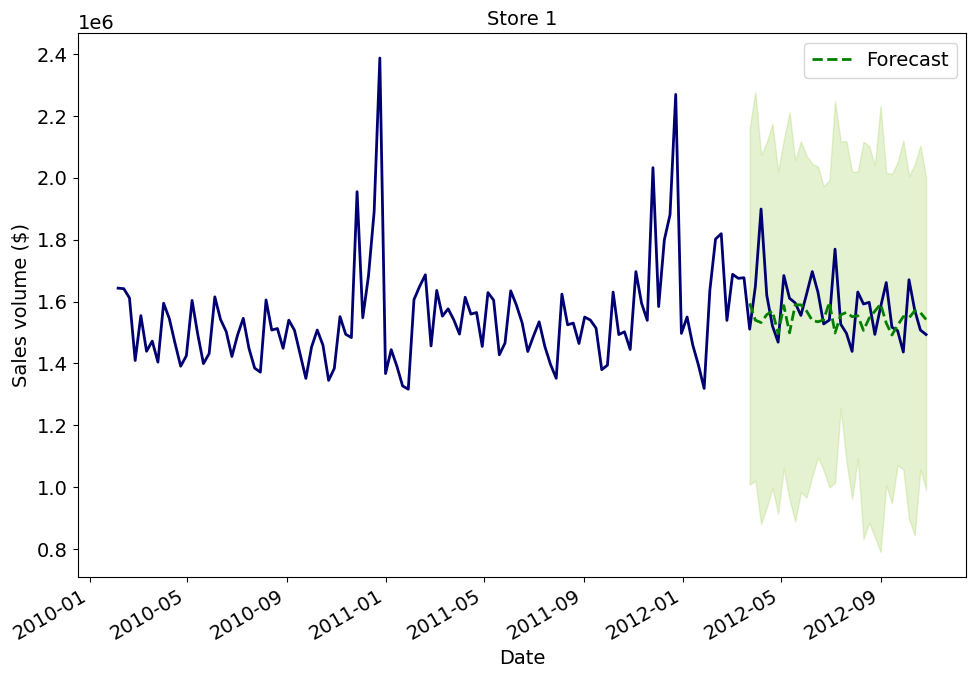

In [30]:
import matplotlib.pyplot as plt

fcsts_64['Date'] = pd.to_datetime(fcsts_64['Date'])

fig, ax = plt.subplots(figsize=(10,7))

ax.plot(df['Date'], df['Weekly_Sales'])
ax.plot(fcsts_64['Date'], fcsts_64['Lag-Llama'], ls='--', color='green', label='Forecast')
ax.fill_between(fcsts_64['Date'], fcsts_64['Lag-Llama-lo-95'], fcsts_64['Lag-Llama-hi-95'], color="#80c21d", alpha=0.2)

ax.set_title(f"Store 1")
ax.set_xlabel('Date')
ax.set_ylabel('Sales volume ($)')
ax.legend(loc=1)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../figures/CH04_F06_peixeiro2.png', dpi=300)
plt.savefig('../figures/CH04_F06_peixeiro2.pdf', format='pdf', bbox_inches='tight')

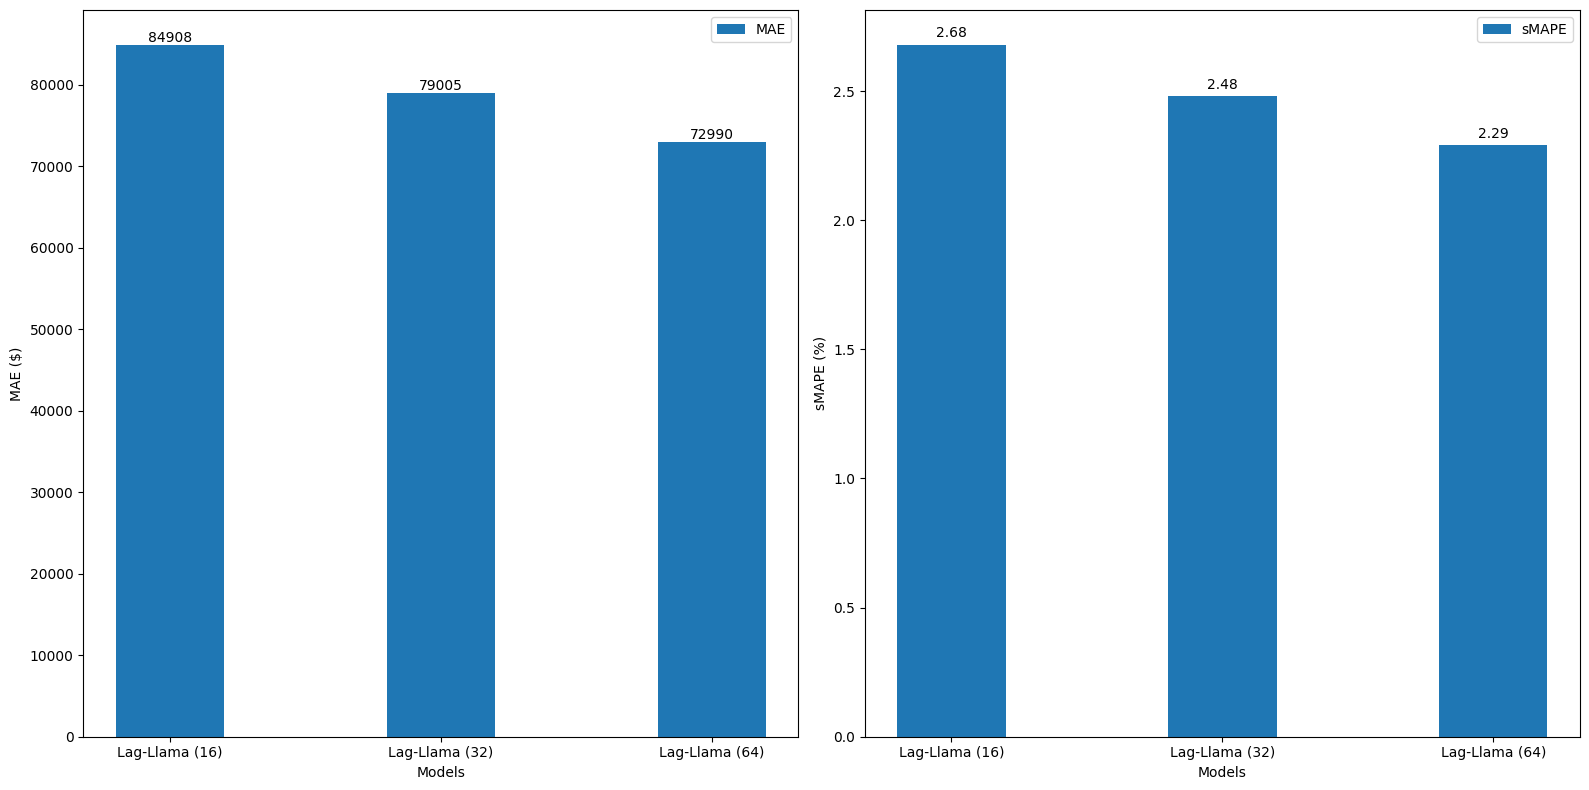

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))

x = ['Lag-Llama (16)', 'Lag-Llama (32)', 'Lag-Llama (64)']
y_mae = [84908, 79005, 72990]
y_smape = [2.68, 2.48, 2.29]

ax1.bar(x, y_mae, width=0.4, label='MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE ($)')
ax1.legend(loc=0)

for i, v in enumerate(y_mae):
    ax1.text(x=i, y=v+300, s=str(v), ha='center')

ax2.bar(x, y_smape, width=0.4, label='sMAPE')
ax2.set_xlabel('Models')
ax2.set_ylabel('sMAPE (%)')
ax2.legend(loc=0)

for i, v in enumerate(y_smape):
    ax2.text(x=i, y=v+.03, s=str(v), ha='center')

plt.tight_layout()

plt.savefig('../figures/CH04_codefig03.png', dpi=300)